<a href="https://colab.research.google.com/github/eyupdalan/BLM6114-project/blob/main/BLM6114_project_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sonuçların analizi

In [34]:
!pip install -q transformers pandas torch scikit-learn matplotlib datasets numpy

### LLama ve Gemma sonuçlarının birleştirilmesi

In [5]:
import pandas as pd
pd_llama = pd.read_csv("gsm8k_tr_classified_with_llama_results.csv")
pd_gemma = pd.read_csv("gsm8k_tr_classified_with_gemma_results.csv")

In [6]:
pd_llama.head()

,question,answer,question_type,solution_method,tr_llama_result,is_tr_llama_correct
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...,oran-orantı,yüzde hesaplama,Sonuç: 108000,0.0
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...,yaş problemi,doğrudan çıkarma,Sonuç: 20,0.0
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.,oran-orantı,birim oran,Sonuç: 8,0.0
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...,çarpma,doğrudan çarpma,Sonuç: 360,0.0
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...,oran-orantı,birim oran,Sonuç: 18,1.0


In [7]:
pd_gemma.head()

,question,answer,question_type,solution_method,gg_gemma_result,is_gg_gemma_correct
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...,oran-orantı,yüzde hesaplama,Sonuç: 270 \n,0.0
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...,yaş problemi,doğrudan çıkarma,Sonuç: 21 \n,1.0
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.,oran-orantı,birim oran,Sonuç: 24 \n,1.0
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...,çarpma,doğrudan çarpma,Sonuç: 90 \n,0.0
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...,oran-orantı,birim oran,Sonuç: 18 \n,1.0


In [9]:
# Seçilen ortak kolonlar ve model özgü kolonlar
common_cols = ["question", "answer", "question_type", "solution_method"]
llama_cols = common_cols + ["tr_llama_result", "is_tr_llama_correct"]
gemma_cols = common_cols + ["gg_gemma_result", "is_gg_gemma_correct"]

# Ortak kolonlarda birleştirme
# 'inner' birleştirme, her iki DataFrame'de de bulunan satırları korur
merged_df = pd.merge(pd_llama[llama_cols], pd_gemma[gemma_cols], on=common_cols, how='inner')

# Birleştirilmiş DataFrame'i kaydetme
merged_df.to_csv("gsm8k_tr_classified_merged_results.csv", index=False)
print("Birleştirilmiş sonuçlar 'gsm8k_tr_classified_merged_results.csv' dosyasına kaydedildi.")

Birleştirilmiş sonuçlar 'gsm8k_tr_classified_merged_results.csv' dosyasına kaydedildi.


In [10]:
merged_df.head()

,question,answer,question_type,solution_method,tr_llama_result,is_tr_llama_correct,gg_gemma_result,is_gg_gemma_correct
0,Borris tekel bayisi her 6 ayda bir 90 kilogram...,Borris şu anda her 6 ayda 90 kilogram üzüm kul...,oran-orantı,yüzde hesaplama,Sonuç: 108000,0.0,Sonuç: 270 \n,0.0
1,"Mel, Katherine'den üç yaş küçük. Katherine ik...",Katherine iki düzine yaşına geldiğinde 24 yaşı...,yaş problemi,doğrudan çıkarma,Sonuç: 20,0.0,Sonuç: 21 \n,1.0
2,James 2 ağacındaki tüm meyveleri toplar. Her ...,James 24 ağaç dikmiştir.,oran-orantı,birim oran,Sonuç: 8,0.0,Sonuç: 24 \n,1.0
3,"Kyle, her biri 15 origami yıldızı alabilen 2 c...",Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...,çarpma,doğrudan çarpma,Sonuç: 360,0.0,Sonuç: 90 \n,0.0
4,Mark'ın iki evcil hayvanı var: Saniyede 10 adı...,Kaplumbağanın yarışı berabere bitirmesi için 1...,oran-orantı,birim oran,Sonuç: 18,1.0,Sonuç: 18 \n,1.0


## Embedding işlemleri

In [14]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

df = pd.read_csv("gsm8k_tr_classified_merged_results.csv")
print("Veri seti okundu:")
print(df.head())

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-e5-large")
model     = AutoModel.from_pretrained("ytu-ce-cosmos/turkish-e5-large").to(device)

def embed_texts(texts, batch_size=16):
  all_embs = []
  for i in range(0, len(texts), batch_size):
    batch = texts[i : i+batch_size]
    enc = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
      last_hidden = model(**enc).last_hidden_state  # (B, L, D)
      emb = last_hidden.mean(dim=1)                 # mean pooling → (B, D)
    all_embs.append(emb.cpu())
  return torch.cat(all_embs, dim=0).numpy()

for col in ["question", "answer", "question_type", "solution_method"]:
  print(f"Embedding yapılıyor: {col}")
  embs = embed_texts(df[col].astype(str).tolist(), batch_size=16)
  df[f"{col}_emb"] = list(embs) # embedding'i sonuna "_emb" eklenerek yeni kolon olarak ekleniyor.
  print(f"Embedding tamamlandı: {col}")


Veri seti okundu:
                                            question  \
0  Borris tekel bayisi her 6 ayda bir 90 kilogram...   
1  Mel, Katherine'den üç yaş küçük.  Katherine ik...   
2  James 2 ağacındaki tüm meyveleri toplar.  Her ...   
3  Kyle, her biri 15 origami yıldızı alabilen 2 c...   
4  Mark'ın iki evcil hayvanı var: Saniyede 10 adı...   

                                              answer question_type  \
0  Borris şu anda her 6 ayda 90 kilogram üzüm kul...   oran-orantı   
1  Katherine iki düzine yaşına geldiğinde 24 yaşı...  yaş problemi   
2                           James 24 ağaç dikmiştir.   oran-orantı   
3  Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...        çarpma   
4  Kaplumbağanın yarışı berabere bitirmesi için 1...   oran-orantı   

    solution_method tr_llama_result  is_tr_llama_correct gg_gemma_result  \
0   yüzde hesaplama   Sonuç: 108000                  0.0   Sonuç: 270 \n   
1  doğrudan çıkarma       Sonuç: 20                  0.0    Sonuç: 21 \n

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Embedding yapılıyor: question
Embedding tamamlandı: question
Embedding yapılıyor: answer
Embedding tamamlandı: answer
Embedding yapılıyor: question_type
Embedding tamamlandı: question_type
Embedding yapılıyor: solution_method
Embedding tamamlandı: solution_method


In [16]:
df.to_pickle("gsm8k_tr_with_embeddings.pkl")

### Lojistik Regresyon

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_pickle("gsm8k_tr_with_embeddings.pkl")

# Her bir embedding'i (list of floats) (N×d_i) dizisine çevir
Q     = np.array(df['question_emb'].tolist())           # shape=(N, d1)
A     = np.array(df['answer_emb'].tolist())             # shape=(N, d2)
QT    = np.array(df['question_type_emb'].tolist())      # shape=(N, d3)
SM    = np.array(df['solution_method_emb'].tolist())    # shape=(N, d4)

# Hepsini birleştir: X shape = (N, d1+d2+d3+d4)
X = np.concatenate([Q, A, QT, SM], axis=1)

## bildi/bilemedi etiketleri
y_llama = df['is_tr_llama_correct'].values
y_gemma = df['is_gg_gemma_correct'].values

X_train, X_test, y_train_llama, y_test_llama, y_train_gemma, y_test_gemma = train_test_split(
    X, y_llama, y_gemma,
    test_size=0.5,
    random_state=42,
)

In [28]:
# Logistic Regression (gg_gemma)
clf = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train_gemma)
y_pred = clf.predict(X_test)

acc_gemma = accuracy_score(y_test_gemma, y_pred)
report_gemma = classification_report(y_test_gemma, y_pred, output_dict=True)

print("Accuracy:", acc_gemma)
print(report_gemma)

Accuracy: 0.7179253867151957
{'0.0': {'precision': 0.8571856287425149, 'recall': 0.7895752895752896, 'f1-score': 0.8219925351708297, 'support': 3626.0}, '1.0': {'precision': 0.2774621212121212, 'recall': 0.38051948051948054, 'f1-score': 0.3209200438116101, 'support': 770.0}, 'accuracy': 0.7179253867151957, 'macro avg': {'precision': 0.5673238749773181, 'recall': 0.5850473850473851, 'f1-score': 0.5714562894912198, 'support': 4396.0}, 'weighted avg': {'precision': 0.7556417022642613, 'recall': 0.7179253867151957, 'f1-score': 0.7342250605696925, 'support': 4396.0}}


Test setindeki tüm örneklerin yaklaşık %71.8'i doğru sınıflanmış.
* Çözülemeyenlerin %85.7'si doğru sınıflanmış (Çözülmedi tahmin edilenlerden gerçekten çözülmemiş olanlar)
* Çözülemeyenlerin %79'u kaçırılmamış. (Gerçekten çözülmemiş olanlardan, çözülmemiş olarak tahmin edilenlerin oranı)
* Çözülenlerin %27.7'si doğru sınıflandırılmış (Çözüldü tahmin edilenlerden gerçekten çözülmüş olanlar)
* Çözülenlerin %38.1'i kaçırılmamış. (Gerçekten çözülmüş olanlardan, çözülmüş olarak tahmin edilenlerin oranı)
* Burada "çözülemeyen"ler genel olarak başarılı bir şekilde tespit edilebilirken, "çözülebilen"lerin tahmini kaçırılıyor.


In [29]:
# Logistic Regression (tr_llama)
clf = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train_llama)
y_pred = clf.predict(X_test)

acc_llama = accuracy_score(y_test_llama, y_pred)
report_llama = classification_report(y_test_llama, y_pred, output_dict=True)

print("Accuracy:", acc_llama)
print(report_llama)

Accuracy: 0.767515923566879
{'0.0': {'precision': 0.8985346972629251, 'recall': 0.8322663252240717, 'f1-score': 0.864131879819197, 'support': 3905.0}, '1.0': {'precision': 0.15917843388960207, 'recall': 0.2525458248472505, 'f1-score': 0.1952755905511811, 'support': 491.0}, 'accuracy': 0.767515923566879, 'macro avg': {'precision': 0.5288565655762636, 'recall': 0.5424060750356612, 'f1-score': 0.5297037351851891, 'support': 4396.0}, 'weighted avg': {'precision': 0.8159541864994352, 'recall': 0.767515923566879, 'f1-score': 0.789425683724885, 'support': 4396.0}}


Test setindeki tüm örneklerin yaklaşık %76.8'i doğru sınıflanmış.
* Çözülemeyenlerin %89.9'u doğru sınıflanmış (Çözülmedi tahmin edilenlerden gerçekten çözülmemiş olanlar)
* Çözülemeyenlerin %83'ü kaçırılmamış. (Gerçekten çözülmemiş olanlardan, çözülmemiş olarak tahmin edilenlerin oranı)
* Çözülenlerin %15.9'u doğru sınıflandırılmış (Çözüldü tahmin edilenlerden gerçekten çözülmüş olanlar)
* Çözülenlerin %25'i kaçırılmamış. (Gerçekten çözülmüş olanlardan, çözülmüş olarak tahmin edilenlerin oranı)
* Burada da "çözülemeyen"ler genel olarak başarılı bir şekilde tespit edilebilirken, "çözülebilen"lerin tahmini kaçırılıyor.


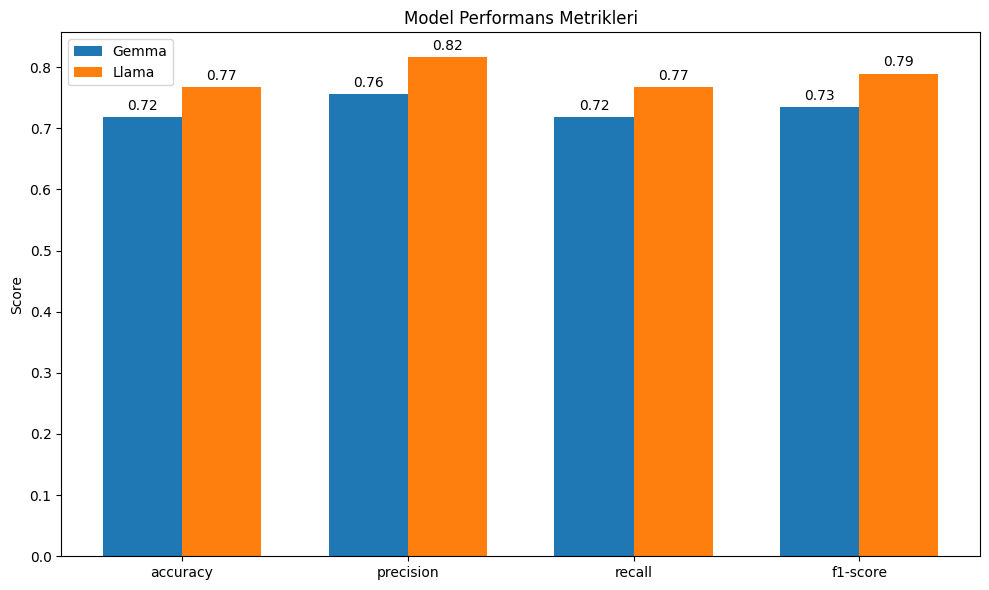

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# report_gemma ve report_llama'dan accuracy, precision, recall, f1-score metriklerini alalım
metrics = ['accuracy', 'precision', 'recall', 'f1-score'] # Accuracy, report'tan alınmıyor, ayrı bir değişken olarak mevcut. Precision, recall, f1-score average değerleri alınacak.

gemma_scores = [
    acc_gemma,
    report_gemma['weighted avg']['precision'],
    report_gemma['weighted avg']['recall'],
    report_gemma['weighted avg']['f1-score']
]

llama_scores = [
    acc_llama,
    report_llama['weighted avg']['precision'],
    report_llama['weighted avg']['recall'],
    report_llama['weighted avg']['f1-score']
]

x = np.arange(len(metrics))  # metrikler için etiket konumları
width = 0.35  # çubukların genişliği

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, gemma_scores, width, label='Gemma')
rects2 = ax.bar(x + width/2, llama_scores, width, label='Llama')

# Eksen etiketleri ve başlık
ax.set_ylabel('Score')
ax.set_title('Model Performans Metrikleri')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Çubukların üzerine değerleri ekle
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()



Genel olarak gemma daha iyi gözüküyor. Ama her ikisi de "çözülememiş" olanları tespitte daha başarılı. "Çözülebilen"leri ikisi de kaçırıyor.

### Embeding Vektörlerinin t-SNE ile 2B Görselleştirmesi

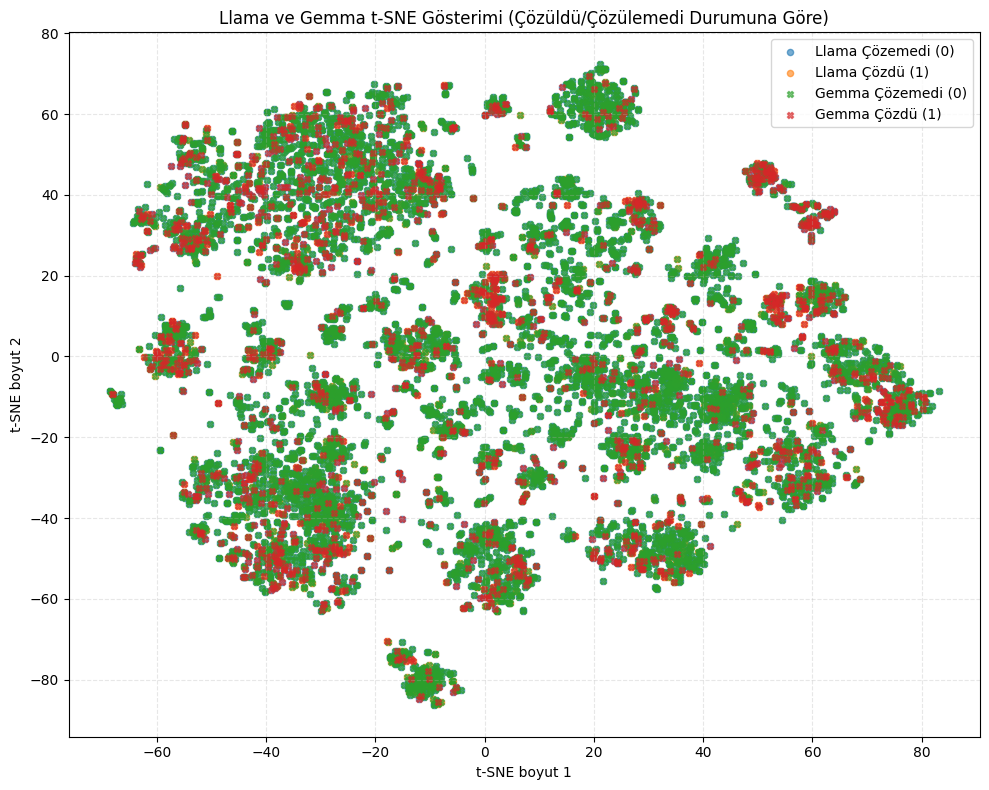

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Örnek:
# X = np.concatenate([Q, A, QT, SM], axis=1)
# y = y_test_llama    # veya y_test_gemma

# t-SNE ile 2 boyuta indirgeme
tsne = TSNE(
    n_components=2,
    perplexity=30,      # veri sayısına göre 5-50 arası değer
    learning_rate='auto',
    init='random',
    random_state=42,
    n_iter=1000
)

# X şu embedding'lerden oluşuyor:
# Q: Question, A: Answer, QT: Question Type, SM: Solutiıon Method
X_2d = tsne.fit_transform(X)

def plot_embedding(X, y_llama, y_gemma, title=None):
    plt.figure(figsize=(10,8))

    # Llama sonuçları için renkler ve etiketler
    colors_llama = ['#1f77b4', '#ff7f0e'] # Mavi: Çözemedi, Turuncu: Çözdü
    labels_llama = ['Llama Çözemedi (0)', 'Llama Çözdü (1)']

    # Gemma sonuçları için renkler ve etiketler (farklı renkler seçelim)
    colors_gemma = ['#2ca02c', '#d62728'] # Yeşil: Çözemedi, Kırmızı: Çözdü
    labels_gemma = ['Gemma Çözemedi (0)', 'Gemma Çözdü (1)']

    # Llama sonuçlarını çizme
    for class_val in np.unique(y_llama):
        idx = (y_llama == class_val)
        plt.scatter(
            X_2d[idx,0], X_2d[idx,1],
            c=colors_llama[int(class_val)],
            label=labels_llama[int(class_val)],
            alpha=0.6,
            s=20,
            marker='o' # Llama için daire
        )

    # Gemma sonuçlarını çizme
    for class_val in np.unique(y_gemma):
         idx = (y_gemma == class_val)
         plt.scatter(
            X_2d[idx,0], X_2d[idx,1],
            c=colors_gemma[int(class_val)],
            label=labels_gemma[int(class_val)],
            alpha=0.6,
            s=20,
            marker='X' # Gemma için çarpı
         )


    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE boyut 1") # Örnekler diyebiliriz
    plt.ylabel("t-SNE boyut 2") # Embedding değerleri
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


y_llama = df['is_tr_llama_correct'].values
y_gemma = df['is_gg_gemma_correct'].values

plot_embedding(X_2d, y_llama, y_gemma, title="Llama ve Gemma t-SNE Gösterimi (Çözüldü/Çözülemedi Durumuna Göre)")

Toplam soru sayısı: 8792
Her iki modelin de doğru çözdüğü soru sayısı: 467
Her iki modelin de yanlış çözdüğü soru sayısı: 6700
Sadece Llama'nın doğru çözdüğü soru sayısı: 534
Sadece Gemma'nın doğru çözdüğü soru sayısı: 1091

İstatistikler (Yüzde):
Her iki modelin de doğru çözdüğü: 5.31%
Her iki modelin de yanlış çözdüğü: 76.21%
Sadece Llama'nın doğru çözdüğü: 6.07%
Sadece Gemma'nın doğru çözdüğü: 12.41%


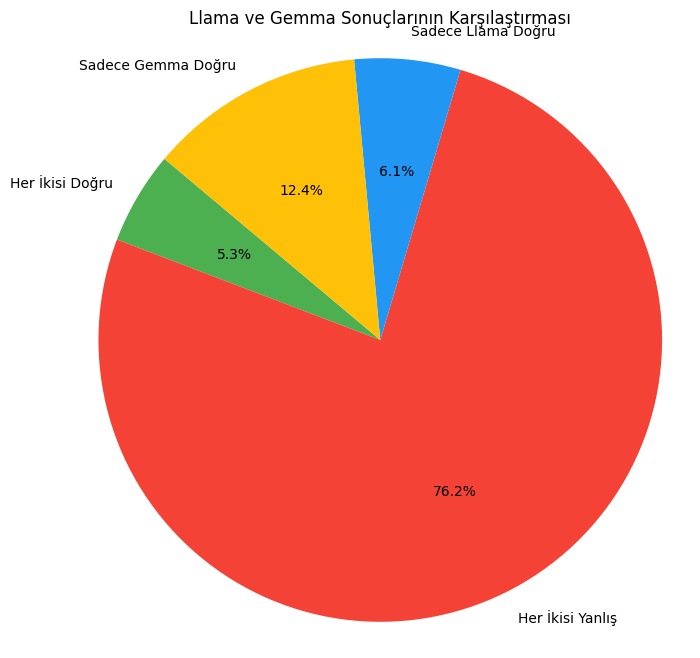

In [43]:
# Her iki modelin de doğru çözdüğü soruların sayısı
both_correct = merged_df[(merged_df['is_tr_llama_correct'] == 1) & (merged_df['is_gg_gemma_correct'] == 1)].shape[0]

# Her iki modelin de yanlış çözdüğü soruların sayısı
both_incorrect = merged_df[(merged_df['is_tr_llama_correct'] == 0) & (merged_df['is_gg_gemma_correct'] == 0)].shape[0]

# Sadece Llama'nın doğru çözdüğü soruların sayısı
llama_only_correct = merged_df[(merged_df['is_tr_llama_correct'] == 1) & (merged_df['is_gg_gemma_correct'] == 0)].shape[0]

# Sadece Gemma'nın doğru çözdüğü soruların sayısı
gemma_only_correct = merged_df[(merged_df['is_tr_llama_correct'] == 0) & (merged_df['is_gg_gemma_correct'] == 1)].shape[0]

# Toplam soru sayısı
total_questions = merged_df.shape[0]

print(f"Toplam soru sayısı: {total_questions}")
print(f"Her iki modelin de doğru çözdüğü soru sayısı: {both_correct}")
print(f"Her iki modelin de yanlış çözdüğü soru sayısı: {both_incorrect}")
print(f"Sadece Llama'nın doğru çözdüğü soru sayısı: {llama_only_correct}")
print(f"Sadece Gemma'nın doğru çözdüğü soru sayısı: {gemma_only_correct}")

# İstatistiklerin yüzdesel gösterimi
print("\nİstatistikler (Yüzde):")
print(f"Her iki modelin de doğru çözdüğü: {(both_correct / total_questions) * 100:.2f}%")
print(f"Her iki modelin de yanlış çözdüğü: {(both_incorrect / total_questions) * 100:.2f}%")
print(f"Sadece Llama'nın doğru çözdüğü: {(llama_only_correct / total_questions) * 100:.2f}%")
print(f"Sadece Gemma'nın doğru çözdüğü: {(gemma_only_correct / total_questions) * 100:.2f}%")

# Grafik çizimi
labels = ['Her İkisi Doğru', 'Her İkisi Yanlış', 'Sadece Llama Doğru', 'Sadece Gemma Doğru']
sizes = [both_correct, both_incorrect, llama_only_correct, gemma_only_correct]
colors = ['#4CAF50', '#F44336', '#2196F3', '#FFC107'] # Yeşil, Kırmızı, Mavi, Sarı

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Llama ve Gemma Sonuçlarının Karşılaştırması')
plt.axis('equal')  # Pasta grafiğinin daire şeklinde olmasını sağlar
plt.show()
